# Download dataset from roboflow in YoloV8 format

In [1]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="Your API Key")
# project = rf.workspace("ali-osama-79dxy").project("car-damage-detection-ft9cy")
# dataset = project.version(2).download("yolov5")

# I have split the train data into train and val

# Import Library

In [2]:
# %%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyparsing-2.4.5-py2.py3-none-any.whl (67 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.7
    Uninstalling pyparsing-2.4.7:
      Successfully uninstalled pyparsing-2.4.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 1.0.8 requires pyparsing==2.4.7, but you have pyparsing 2.4.5 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 2.4.5
    Uninstalling pyparsing-2.4.5:
      Successfully uninstalled py

In [3]:
import torch
torch.__version__

'1.13.1+cu117'

In [4]:
import torch
torch.cuda.get_device_name(0)

'Tesla T4'

# Fine-tuning YOLONAS on custom dataset

Fine Tune means use pretrained model that fine tune that on custom dataset

### The Trainer

1) ckpt_root_dir - this is the directory where results from all your experiments will be saved

2)experiment_name - all checkpoints, logs, and tensorboards will be saved in a directory with the name you specify here.

In [5]:
# If an error exist then restart the runtime
from super_gradients.training import Trainer

[2023-05-14 14:01:44] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-05-14 14:01:54] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-14 14:01:54] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-14 14:01:54] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-14 14:01:54] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [6]:
from google.colab import drive
drive.mount('/content/drive')

In [7]:
CHECKPOINT_DIR = 'checkpoints'

In [8]:
trainer = Trainer(experiment_name='my_yolonas_model', ckpt_root_dir=CHECKPOINT_DIR)

# Dataset and DataLoader

In [9]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [18]:
dataset_params = {
    'data_dir':'/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/YOLO-NAS-main/My_YOLO_NAS/cardamage',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'val/images',
    'val_labels_dir':'val/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': [0, 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 2, 3, 4, 5, 6, 7, 9, 'door', 'front_bumper', 'headlamp', 'hood', 'rear_bumper']
}

DataLoader

In [19]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

Caching annotations: 100%|██████████| 12/12 [00:00<00:00, 356.80it/s]


# Data Augmentation - Just using the inbuilt Library

SuperGradients added transforms. we can experiment with transforms, albumentations or a custom tranformaton.

In [20]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [21]:
train_data.dataset.dataset_params['transforms'][1]

{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [22]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42

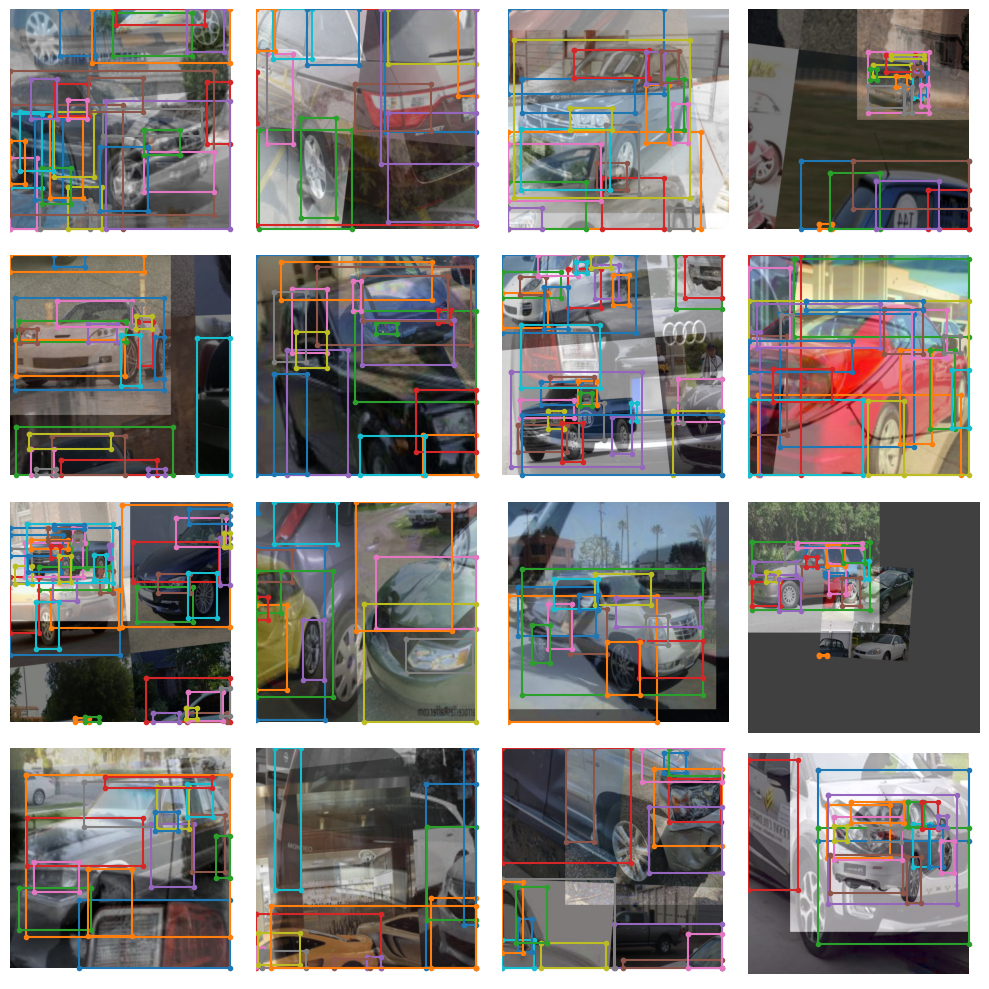

In [23]:
train_data.dataset.plot()

# Initialize the Model

In [24]:
from super_gradients.training import models

In [25]:
# Pretrained model
model = models.get('yolo_nas_l', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )

[2023-05-14 14:06:19] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


  0%|          | 0.00/256M [00:00<?, ?B/s]

Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth


There are a few mandatory arguments that we must define for training params:

max_epochs - Max number of training epochs

loss - the loss function you want to use

optimizer - Optimizer you will be using

train_metrics_list - Metrics to log during training

valid_metrics_list - Metrics to log during training

metric_to_watch - metric which the model checkpoint will be saved according to

We can choose from a variety of optimizer's such as: Adam, AdamW, SGD, Lion, or RMSProps. 

If we choose to change the defualt parameters of these optimizrs we pass them into optimizer_params.

In [26]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

I've enabled silent_mode so the notebook doesn't get longer

In [27]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 10,
    # if GPU cude - turn this to true
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# If error - Restart and Run all 

In [28]:
# training the model
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-05-14 14:06:28] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-05-14 14:06:35] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to checkpoints/my_yolonas_model/console_May14_14_06_36.txt


[2023-05-14 14:06:44] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 139        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         8          (len(train_loader))
    - Gradient updates per epoch:   8          (len(train_loader) / batch_accumulate)

[2023-05-14 14:07:14] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_yolonas_model/ckpt_best.pth
[2023-05-14 14:07:14] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0009233611635863781
[2023-05-14 14:07:45] INFO - base_sg_logger.py - Checkpoint saved in chec

SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 2.3897
│   │   ├── Best until now = 2.4684 (↘ -0.0788)
│   │   └── Epoch N-1      = 2.4684 (↘ -0.0788)
│   ├── Ppyoloeloss/loss_cls = 1.1515
│   │   ├── Best until now = 1.1943 (↘ -0.0428)
│   │   └── Epoch N-1      = 1.1943 (↘ -0.0428)
│   ├── Ppyoloeloss/loss_dfl = 1.3289
│   │   ├── Best until now = 1.3782 (↘ -0.0493)
│   │   └── Epoch N-1      = 1.3782 (↘ -0.0493)
│   └── Ppyoloeloss/loss_iou = 0.2295
│       ├── Best until now = 0.234  (↘ -0.0045)
│       └── Epoch N-1      = 0.234  (↘ -0.0045)
└── Validation
    ├── F1@0.50 = 0.1103
    │   ├── Best until now = 0.1057 (↗ 0.0047)
    │   └── Epoch N-1      = 0.1057 (↗ 0.0047)
    ├── Map@0.50 = 0.3514
    │   ├── Best until now = 0.343  (↗ 0.0085)
    │   └── Epoch N-1      = 0.343  (↗ 0.0085)
    ├── Ppyoloeloss/loss = 2.9299
    │   ├── Best until now = 3.4026 (↘ -0.4727)
    │   └── Epoch N-1      = 4.042  (↘ -1.1121)
    ├── Ppyoloeloss/loss_cls = 1.6358
    │   ├── B

# Get the best model from checkpoint

In [29]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="/content/checkpoints/my_yolonas_model/ckpt_best.pth")

# Evaluating the best trained model on the test set

In [30]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))

Test: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


{'PPYoloELoss/loss_cls': 2.350487,
 'PPYoloELoss/loss_iou': 0.2061797,
 'PPYoloELoss/loss_dfl': 1.3400317,
 'PPYoloELoss/loss': 3.5359523,
 'Precision@0.50': tensor(0.0478),
 'Recall@0.50': tensor(0.7789),
 'mAP@0.50': tensor(0.3961),
 'F1@0.50': tensor(0.0849)}

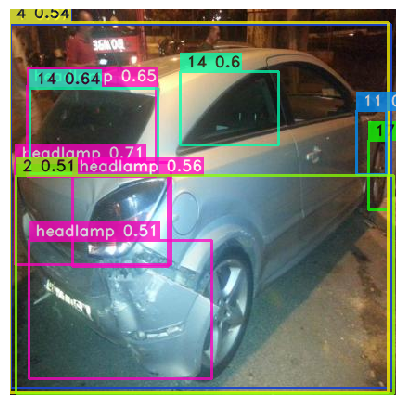

In [38]:
test_image = '/content/drive/MyDrive/Colab_Notebooks/ObjectDetection/YOLO-NAS-main/My_YOLO_NAS/cardamage/test/images/24_jpg.rf.d89a4844876c682f79a2b962e586af52.jpg'
best_model.predict(test_image).show()